<a href="https://colab.research.google.com/github/RuinedPenguin/SMAI-IIITH-Assignments/blob/main/Assignment%203/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import unittest

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid", {'axes.grid' : False})

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import torchsummary

%matplotlib inline

# Tensors

A tensor is an n-dimensional array consisting of elements of the same type. Every tensor has an associated shape that describes the dimensions of the tensor. For example, the shape of a 4D tensor would have four numbers that specify the size of each of the four dimensions.

- **vector:** 1D tensor with shape `[N]` where N denotes the number of elements
- **matrix:** 2D tensor with shape `[R, C]` where R and C denote the number of rows and columns, respectively
- **RGB image:** 3D tensor with shape `[C, H, W]` where C denotes the number of channels (representing color) and H and W denote the height and width, respectively

The number of tensor dimensions is known as "the rank of the tensor". Each tensor dimension is known as "an axis" of the tensor. An axis with a dimension of one is known as a singleton axis. Example usage: "In a rank four tensor of shape `[N, C, H, W]`, N denotes the dimension/size of the leading axis."

A tensor containing a batch of images would typically have the following shape: [N, C, H, W]. `N` indicates the number of images in the batch, `C` indicates the number of channels (one for grayscale images and typically three for color images), H and W are the height and width of the image respectively. Note that the dimensions of each image is fixed; we cannot store images of different sizes in the same tensor.

# Convolution Arithmetic

The convolution operation takes two tensors as input and results in one tensor as output (sometimes, we add a "bias" tensor to the result after convolving). The shape of the output tensor depends on the shape of the input tensor, weights/filters tensor, and convolution configuration such as padding.

The convolution layer in a neural network generally convolves the same input with many filters (ranging from few dozen to hundreds to thousands). It is equivalent to convolving the image with each filter separately and then concatenating the results into a single tensor. We also often convolve the same set of filters on a collection of input tensors (like in minibatch gradient descent).

Using the visualizations below as an aid, write a function that outputs the shape of the output tensor for a given input shape, filters shape, and convolution configuration.

<table>
  <tr>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/full_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Padding of one, no strides</td>
    <td>Padding of two, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides_odd.gif"></td>
  </tr>
  <tr>
    <td>No padding, stride of two</td>
    <td>Padding of one, stide of two</td>
    <td>Padding of one, stride of two</td>
  </tr>
</table>

**References:**
"A guide to convolution arithmetic for deep learning", https://arxiv.org/abs/1603

License for images: https://github.com/vdumoulin/conv_arithmetic/blob/master/LICENSE


In [2]:
def getConvolutionOutputShape(B, C, H, W, K, M, N, Ph=0, Pw=0, Sh=1, Sw=1):
  """
    Computes the output shape of 2D convolution for a given input and filters shape

    Input shape: [B, C, H, W]
    Filters shape: [K, C, M, N]
    
    Padding and strides are relevant for spatial dimensions only (height and width).

  Args:
    B: batch size
    C: number of input channels
    H: height of the input
    W: width of the input
    K: number of filters
    M: height of the filters
    N: width of the filters
    Ph: vertical padding
    Pw: horizontal padding
    Sh: vertical stride
    Sw: horizontal stride
  """

  output_shape = np.zeros(4, dtype=int)

  # the calculation is independent and identical for each spatial axis
  def calculate_output_dim(input_size, filter_size, padding, stride):
    """returns the output dimension for a spatial axis"""
    # YOUR CODE BEGINS HERE
    return (input_size - filter_size + 2 * padding + 1) / stride
    # YOUR CODE ENDS HERE

  # YOUR CODE BEGINS HERE
  output_shape[0] = B
  output_shape[1] = K
  output_shape[2] = calculate_output_dim(H, M, Ph, Sh)
  output_shape[3] = calculate_output_dim(W, N, Pw, Sw)
  # YOUR CODE ENDS HERE

  return list(output_shape)

In [3]:
class Test_getConvolutionOutputShape(unittest.TestCase):
  def test_simple(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 28, 32, 16, 3, 3), [1, 16, 26, 30])
    self.assertEqual(getConvolutionOutputShape(5, 3, 32, 28, 32, 3, 3), [5, 32, 30, 26])
    self.assertEqual(getConvolutionOutputShape(7, 256, 28, 28, 64, 3, 1), [7, 64, 26, 28])
    self.assertEqual(getConvolutionOutputShape(11, 256, 28, 28, 128, 1, 3), [11, 128, 28, 26])
    self.assertEqual(getConvolutionOutputShape(13, 1, 64, 64, 16, 5, 5), [13, 16, 60, 60])

  def test_padding(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 32, 28, 16, 3, 3, 1, 1), [1, 16, 32, 28])
    self.assertEqual(getConvolutionOutputShape(1, 16, 28, 32, 32, 3, 3, 3, 3), [1, 32, 32, 36])
    self.assertEqual(getConvolutionOutputShape(1, 33, 28, 28, 64, 3, 1, 1, 0), [1, 64, 28, 28])
    self.assertEqual(getConvolutionOutputShape(1, 64, 28, 28, 128, 1, 3, 0, 1), [1, 128, 28, 28])
    self.assertEqual(getConvolutionOutputShape(1, 32, 28, 28, 128, 1, 3, 0, 1), [1, 128, 28, 28])
    self.assertEqual(getConvolutionOutputShape(1, 4, 7, 11, 16, 5, 5, 2, 2), [1, 16, 7, 11])

  def test_strides(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 28, 28, 16, 3, 3, 0, 0, 2, 2), [1, 16, 13, 13])
    self.assertEqual(getConvolutionOutputShape(1, 32, 28, 28, 32, 3, 3, 1, 1, 2, 2), [1, 32, 14, 14])
    self.assertEqual(getConvolutionOutputShape(1, 64, 28, 28, 64, 3, 1, 2, 2, 2, 2), [1, 64, 15, 16])
    self.assertEqual(getConvolutionOutputShape(1, 128, 28, 28, 128, 1, 3, 0, 1, 4, 4), [1, 128, 7, 7])

  def test_misc(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 13, 13, 16, 1, 1), [1, 16, 13, 13])

unittest.main(Test_getConvolutionOutputShape(), argv=[''], verbosity=2, exit=False)

test_misc (__main__.Test_getConvolutionOutputShape) ... ok
test_padding (__main__.Test_getConvolutionOutputShape) ... ok
test_simple (__main__.Test_getConvolutionOutputShape) ... ok
test_strides (__main__.Test_getConvolutionOutputShape) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.014s

OK


# Convolution

Implement the `convolve2d` that convolves a filter (unit strides and zero padding) on a greyscale image. The animated visual aid shows this configuration.

<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif"/>

In [4]:
def convolve2d(image, kernel):
  """
    Convolve a 2D image with a kernel (2D filter)

  Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
  """

  image = np.asarray(image)
  kernel = np.asarray(kernel)

  H, W = image.shape
  M, N = kernel.shape

  # YOUR CODE BEGINS HERE
  result_H = H - M + 1
  result_W = W - N + 1
  # YOUR CODE ENDS HERE

  result = np.zeros((result_H, result_W), dtype=np.float32)
  # YOUR CODE BEGINS HERE
  # Implement convolution using two loops
  for h in range(result_H):
    for w in range(result_W):
        result[h,w] = np.sum(image[h:h+M, w:w+N] * kernel)
  # YOUR CODE ENDS HERE

  return result

In [5]:
def convolve2d_ref(image, kernel):
  from scipy import signal
  return signal.correlate2d(image, kernel, mode='valid')

class test_convolve2d(unittest.TestCase):
  def test(self):
    image1 = np.random.random((16, 16))
    kernel1 = np.ones((3, 3), dtype=np.float32)
    kernel1 /= np.sum(kernel1)
    self.assertTrue(np.allclose(convolve2d(image1, kernel1), convolve2d_ref(image1, kernel1), rtol=1e-05, atol=1e-08))

    image2 = np.random.random((32, 32))
    kernel2 = np.asarray([[1, 2, 3], [4, 5, 6], [6, 7, 8]], dtype=np.float32)
    kernel2 /= np.sum(kernel2)
    self.assertTrue(np.allclose(convolve2d(image2, kernel2), convolve2d_ref(image2, kernel2), rtol=1e-05, atol=1e-08))

    image3 = np.random.random((256, 256))
    kernel3 = np.asarray([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
    kernel3 /= np.sum(np.abs(kernel3))
    self.assertTrue(np.allclose(convolve2d(image3, kernel3), convolve2d_ref(image3, kernel3), rtol=1e-05, atol=1e-08))

unittest.main(test_convolve2d(), argv=[''], verbosity=2, exit=False)

test (__main__.test_convolve2d) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.573s

OK


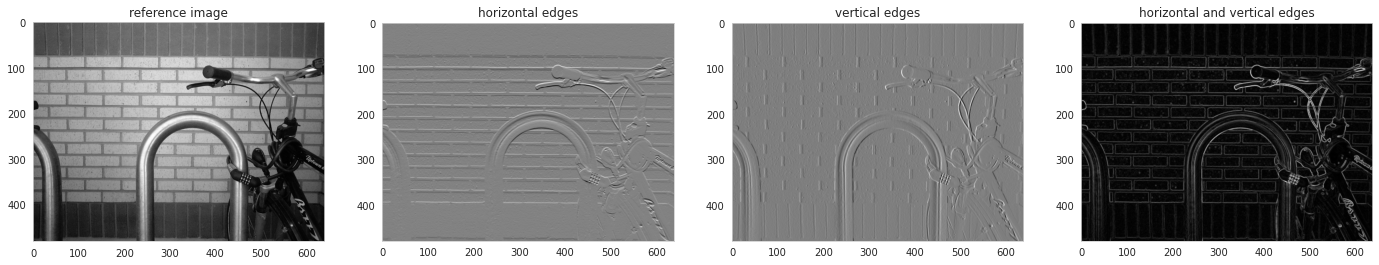

In [6]:
import skimage.io as sio
image = sio.imread("https://upload.wikimedia.org/wikipedia/commons/3/3f/Bikesgray.jpg", as_gray=True)

# https://en.wikipedia.org/wiki/Sobel_operator
sobel_filter_horizontal = np.asarray([
  [ 1,  2,  1],
  [ 0,  0,  0],
  [-1, -2, -1]
], dtype=np.float32)

sobel_filter_vertical = sobel_filter_horizontal.T

# convolve image with Sobel operators using your implementation
image_sobel_h = convolve2d(image, sobel_filter_horizontal)
image_sobel_v = convolve2d(image, sobel_filter_vertical)
image_sobel_hv =  np.sqrt(image_sobel_h**2 + image_sobel_v**2)

# convolve image with Sobel operators using reference implementation
image_sobel_h_ref = convolve2d_ref(image, sobel_filter_horizontal)
image_sobel_v_ref = convolve2d_ref(image, sobel_filter_vertical)

fig, axes = plt.subplots(1, 4, figsize=(24,6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("reference image")
axes[1].imshow(image_sobel_h, cmap='gray')
axes[1].set_title("horizontal edges")
axes[2].imshow(image_sobel_v, cmap='gray')
axes[2].set_title("vertical edges")
axes[3].imshow(image_sobel_hv, cmap='gray')
axes[3].set_title("horizontal and vertical edges")
plt.show()

# Convolution as Matrix Multiplication

Convolution is a linear operation. We can represent convolution as a matrix multiplication of a transformed filter matrix with the input matrix.

Consider an input $\mathbf{X}$ and a kernel $\mathbf{W}$.

$$$$

$$\mathbf{X} = \begin{pmatrix}x_{00} & x_{01} & x_{02} \\ x_{10} & x_{11} & x_{12} \\ x_{20} & x_{21} & x_{22} \end{pmatrix}\$$

$$\mathbf{W} = \begin{pmatrix}w_{00} & w_{01} \\ w_{10} & w_{11} \end{pmatrix}$$

$$$$

Let the result of the convolution of $\mathbf{X}$ with $\mathbf{W}$ be denoted by $\mathbf{Y}$.

$$\mathbf{Y} = \mathbf{X} * \mathbf{Y}$$

$$\mathbf{Y} = \begin{pmatrix}
w_{00}*x_{00} + w_{01}*x_{01} + w_{10}*x_{10} + w_{11}*x_{11} &
w_{00}*x_{01} + w_{01}*x_{02} + w_{10}*x_{11} + w_{11}*x_{12} \\
w_{00}*x_{10} + w_{01}*x_{11} + w_{10}*x_{20} + w_{11}*x_{21} &
w_{00}*x_{11} + w_{01}*x_{12} + w_{10}*x_{21} + w_{11}*x_{22}
 \end{pmatrix}$$

$$$$

We can express the result as matrix multiplication of a transformed weight matrix with the input matrix.

$$\mathbf{Y} = \begin{pmatrix}
w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0 & 0 & 0 \\
0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0  & 0\\
0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 \\
0 & 0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

1. Assuming the input and kernel shape to be `[H, W]` and `[M, N]` respectively, what is the shape of the transformed kernel matrix?
2. Complete the `transform_kernel` function. It must construct the transformed kernel matrix for a given input shape and kernel matrix.
3. Complete the `convolve2d_matmul` function. It must convolve the input with the given kernel using the transformed matrix.

**References:**
- https://github.com/alisaaalehi/convolution_as_multiplication

## Answers

1. Shape of the transformed kernel matrix will be [(H-M+1) * (W -N+1), H * W]

In [7]:
def transform_kernel(image, kernel):
  """
    Transform kernel matrix into a new matrix such that matrix multiplication of
    the transformed matrix with the flattened input gives the result of convolution.

  Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
  """

  image = np.asarray(image)
  kernel = np.asarray(kernel)

  H, W = image.shape
  M, N = kernel.shape

  # YOUR CODE BEGINS HERE
  result_H = (H - M + 1) # height of the output
  result_W = (W - N + 1)# width of the output
  # YOUR CODE ENDS HERE

  transformed_kernel = np.zeros((result_H * result_W, H * W), dtype=np.float32)
  # YOUR CODE BEGINS HERE
  padded_k = np.zeros((M, W))
  padded_k[:, 0:N] = kernel
  new_k_row = padded_k.reshape((-1))
  l = H * (M-1) + N
  new_k_row = new_k_row[0 : l]
  index_x = 0
  for i in range(0, transformed_kernel.shape[0], result_W):
    for j in range(result_W):
      # print(transformed_kernel)
      transformed_kernel[i+j, index_x + j : index_x + j + l] = new_k_row
    index_x += W

  # YOUR CODE ENDS HERE

  return transformed_kernel

def convolve2d_matmul(image, kernel):
  """
    Convolve a 2D image with a 2D kernel

  Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
  """

  image = np.asarray(image)
  kernel = np.asarray(kernel)
  
  H, W = image.shape
  M, N = kernel.shape

  # YOUR CODE BEGINS HERE
  result_H = H - M + 1
  result_W = W - N + 1
  # YOUR CODE ENDS HERE

  # YOUR CODE BEGINS HERE
  # 1. compute transformed kernel
  trans_kernel = transform_kernel(image, kernel)
    
  # 2. flatten input (reshape the 2D input to a 1D column vector)
  flat_im = image.reshape((-1))
    
  # 3. matrix multiplication
  result_vec = np.dot(trans_kernel, flat_im)

  # 4. reshape result (reshape back to 2D output from a 1D column vector)
  result = result_vec.reshape((result_H, result_W))
  # YOUR CODE ENDS HERE

  return result

In [8]:
def convolve2d_ref(image, kernel):
  from scipy import signal
  return signal.correlate2d(image, kernel, mode='valid')

class test_convolve2d_matmul(unittest.TestCase):
  def test(self):
    image1 = np.random.random((16, 16))
    kernel1 = np.ones((3, 3), dtype=np.float32)
    kernel1 /= np.sum(kernel1)
    self.assertTrue(np.allclose(convolve2d_matmul(image1, kernel1), convolve2d_ref(image1, kernel1), rtol=1e-05, atol=1e-08))

    image2 = np.random.random((32, 32))
    kernel2 = np.asarray([[1, 2, 3], [4, 5, 6], [6, 7, 8]], dtype=np.float32)
    kernel2 /= np.sum(kernel2)
    self.assertTrue(np.allclose(convolve2d_matmul(image2, kernel2), convolve2d_ref(image2, kernel2), rtol=1e-05, atol=1e-08))

    image3 = np.random.random((64, 64))
    kernel3 = np.asarray([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
    kernel3 /= np.sum(np.abs(kernel3))
    self.assertTrue(np.allclose(convolve2d_matmul(image3, kernel3), convolve2d_ref(image3, kernel3), rtol=1e-05, atol=1e-08))

unittest.main(test_convolve2d_matmul(), argv=[''], verbosity=2, exit=False)

test (__main__.test_convolve2d_matmul) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.147s

OK


## Comparing convolutional layer with fully-connected layer

$$\mathbf{Y}_{fc} = \begin{pmatrix}
w_{00} & w_{01} & w_{02} & w_{03} & w_{04} & w_{05} & w_{06} & w_{07} & w_{08} & w_{09} \\
w_{10} & w_{11} & w_{12} & w_{13} & w_{14} & w_{15} & w_{16} & w_{17} & w_{18} & w_{19} \\
w_{20} & w_{21} & w_{22} & w_{23} & w_{24} & w_{25} & w_{26} & w_{27} & w_{28} & w_{29} \\
w_{30} & w_{31} & w_{32} & w_{33} & w_{34} & w_{35} & w_{36} & w_{37} & w_{38} & w_{39}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

$$\mathbf{Y}_{conv} = \begin{pmatrix}
w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0 & 0 & 0 \\
0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0  & 0\\
0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 \\
0 & 0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

## Questions

1. Express the number of learnable parameters in a convolutional layer (without bias) in terms of `B`, `K`, `C`, `H`, `W`, `M` and `N` (as defined earlier).
2. Express the number of learnable parameters in a fully-connected layer (without bias) in terms of the number of inputs `N` and outputs `M`.
4. Imagine weight matrices of a convolutional and fully-connected layer such that both operations result in the same output shape for a given input shape (the transformed toeplitz matrix must have the same shape of the fully-connected layer weights). Run the next code cell. What patterns do you observe in the weights? Is the weights matrix dense or sparse?
4. Explain what you understand by the terms "sparse connectivity" and "weight sharing" in the context of convolutional layers.
5. If a fully-connected layer can mimic convolution and is more powerful in terms of the set of functions it can represent, what is the point of using convolutions instead of them?


## Answers

1. No. of trainable parameters in a convolutional layer (without bias) = K * C * M * N

2. No. of trainable parameters in a fully-connected layer (without bias) = N * M

In [9]:
with np.printoptions(threshold=sys.maxsize, linewidth=128):
  print("A weight matrix of fully-connected that takes an input of 5x5 (flattened to 25) and results in an output with shape 3x3 (flattened to 9)")
  print(np.arange(9 * 25, dtype=np.float32).reshape(9, 25))
  print()

  print("Transformed matrix for 3x3 kernel that operates on an input with shape 5x5")
  print(transform_kernel(np.zeros((5, 5)), [[1, 2, 3], [4, 5, 6], [7, 8, 9]]))
  print()

A weight matrix of fully-connected that takes an input of 5x5 (flattened to 25) and results in an output with shape 3x3 (flattened to 9)
[[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.]
 [ 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.]
 [ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.]
 [ 75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99.]
 [100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.]
 [125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149.]
 [150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168

3. For weights matrix of FC, we observe a straight inline pattern showing that the vector has just been reshaped. For Convolution layer, we observe a weight matrix which follows a circular pattern.
<br>FC weigth matrix - Dense
<br>Convolution layer weight matrix - Sparse 

4. Sparse connectivity - This implies that the weights (kernel) are connected to a smaller and limited number of inputs at a time. This can help in saving mmory and also optimising computational power.
   <br>Weight sharing - In CNN the kernel is moved across the whole image, implying that this kernel has been replicated on many subparts of the image, hence the weights have been shared. This helps the layer respond to a same type of feature.

5. When we have a input vector with a very large size, like images, the fully connected layer will require a significantly large number of weights to be trained compared to convolutional layer. This will result in slower training times and might also lead to overfitting. Hence, convolutional layers exist, as their sparse connectivity and weight sharing helps in reducing training time and reduces the chances of overfitting.


# Training Convolutional Neural Networks

You have to train an image classifier for CIFAR10 dataset. There are ten classes/labels in the dataset. Each image has the shape 3x32x32 (32 pixels wide and tall, with 3 color channels).The dataset consists of 50,000 training samples and 10,000 test samples.

In [10]:
# On Google Colab: Go to "Runtime" > "Change runtime type" > Select "GPU"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

device: cpu


In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='data', download=True, train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data', download=True, train=False, transform=transform)

print("training dataset size:", len(train_dataset))
print("test dataset size:", len(test_dataset))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
training dataset size: 50000
test dataset size: 10000


In [12]:
# YOUR CODE BEGINS HERE
# portion a part of the training dataset for validation
# use 90% of the training dataset for training and the rest for validation
# use `torch.utils.data.random_split`
original_train_size = len(train_dataset)
train_size = int(0.9 * original_train_size)
valid_size = int(0.1 * original_train_size)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
# YOUR CODE ENDS HERE

print("training dataset size:", train_size)
print("validation dataset size:", valid_size)

training dataset size: 45000
validation dataset size: 5000


In [13]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset)
test_dataloader = torch.utils.data.DataLoader(test_dataset)

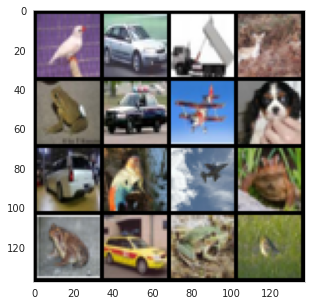

In [14]:
images, _ = next(iter(train_dataloader))
images = images * 0.5 + 0.5 # undo normalization for displaying images
plt.figure(figsize=(5,5))
plt.imshow(torchvision.utils.make_grid(images, nrow=4).permute(1, 2, 0))

In [ ]:
class SMAIConvNet(nn.Module):
  def __init__(self):
    super(SMAIConvNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same')
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    # YOUR CODE BEGINS HERE
    # Conv2D with 32 filters, 3x3 kernel and 'same' padding
    # MaxPool2D with with window size 2x2
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding='same')
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)

    # Conv2D with 32 filters, 3x3 kernel and 'same' padding
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')

    # Linear layer with 128 output features
    # Dropout with drop probability of 0.2
    self.fc1 = nn.Linear(in_features = 2048, out_features = 128)
    self.dropout1 = nn.Dropout(p=0.2)

    # Linear layer with 10 output features
    self.fc2 = nn.Linear(in_features = 128, out_features = 10)
    # YOUR CODE ENDS HERE

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = F.relu(x)

    # YOUR CODE BEGINS HERE
    # conv2 > maxpool2 > ReLU
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = F.relu(x)

    # conv3 > ReLU
    x = self.conv3(x)
    x = F.relu(x)

    # fc1 > dropout1 > ReLU
    # if len(x.shape) == 4:
    #   x = torch.flatten(x,1)
    # else:
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.dropout1(x)
    x = F.relu(x)

    # fc2
    x = self.fc2(x)
    # YOUR CODE ENDS HERE
    return x

In [ ]:
torchsummary.summary(SMAIConvNet().to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
         MaxPool2d-2            [-1, 8, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           2,336
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 32, 8, 8]           9,248
            Linear-6                  [-1, 128]         262,272
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 275,370
Trainable params: 275,370
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.17
Params size (MB): 1.05
Estimated Total Size (MB): 1.24
----------------------------------------------------------------


In [ ]:
def train(model, device, train_dataloader, optimizer, criterion):
  """trains for one epoch"""
  
  model.train()
  accumulated_loss = 0.0
  for data in train_dataloader:
    (inputs, labels) = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # YOUR CODE BEGINS HERE
    # 1. zero existing gradients
    optimizer.zero_grad()

    # 2. forward the inputs
    outputs = model.forward(inputs)

    # 3. compute the loss
    loss = criterion(outputs, labels)

    # 4. backprop the loss
    loss.backward()

    # 5. update the weights
    optimizer.step()
    
    # YOUR CODE ENDS HERE

    accumulated_loss += loss.item()
  return accumulated_loss / len(train_dataloader)

def test(model, device, dataloader, criterion):
  model.eval()
  accumulated_loss = 0.0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      (inputs, labels) = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # YOUR CODE BEGINS HERE
      # 1. forward the inputs
      outputs = model.forward(inputs)

      # 2. compute the loss
      loss = criterion(outputs, labels)
      
      # YOUR CODE ENDS HERE

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      accumulated_loss += loss.item()

      predictions = outputs.argmax(dim=1)
      correct += (predictions == labels).sum()

    num_samples = len(dataloader)
    avg_loss = accumulated_loss / num_samples
    return avg_loss, correct / num_samples
    

In [ ]:
model = SMAIConvNet().to(device) # resets parameters

# YOUR CODE BEGINS HERE
# use CrossEntropyLoss
# use SGD with a lr=0.001 and momentum=0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = model.parameters(), lr=0.001, momentum=0.9)
# YOUR CODE ENDS HERE

best_val_loss = np.Inf
loss_history = { "train" : [], "validation" : []}
for epoch in range(30):
  train_loss = train(model, device, train_dataloader, optimizer, criterion)
  loss_history["train"].append(train_loss)

  val_loss, val_acc = test(model, device, valid_dataloader, criterion)
  loss_history["validation"].append(val_loss)

  if val_loss < best_val_loss and (best_val_loss - val_loss) > 1e-3:
    print("new best model")
    torch.save(model.state_dict(), "best_model.pth")
    best_val_loss = val_loss

  print("[%d] training loss: %.2f" % (epoch + 1,train_loss))
  print("[%d] validation loss: %.2f, validation accuracy: %.2f%%" % (epoch + 1, val_loss, val_acc * 100))
  print()

new best model
[1] training loss: 2.00
[1] validation loss: 1.76, validation accuracy: 36.74%

new best model
[2] training loss: 1.58
[2] validation loss: 1.45, validation accuracy: 47.10%

new best model
[3] training loss: 1.37
[3] validation loss: 1.27, validation accuracy: 55.08%

new best model
[4] training loss: 1.23
[4] validation loss: 1.17, validation accuracy: 57.96%

new best model
[5] training loss: 1.12
[5] validation loss: 1.10, validation accuracy: 61.60%

new best model
[6] training loss: 1.03
[6] validation loss: 1.03, validation accuracy: 63.64%

new best model
[7] training loss: 0.95
[7] validation loss: 0.98, validation accuracy: 65.76%

new best model
[8] training loss: 0.89
[8] validation loss: 0.93, validation accuracy: 68.70%

new best model
[9] training loss: 0.83
[9] validation loss: 0.89, validation accuracy: 68.78%

new best model
[10] training loss: 0.77
[10] validation loss: 0.87, validation accuracy: 70.00%

new best model
[11] training loss: 0.73
[11] val

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))

test_loss, test_acc = test(model, device, test_dataloader, criterion)
print("test loss: %.2f, test accuracy: %.2f%%" % (test_loss, test_acc * 100))

test loss: 0.85, test accuracy: 70.54%


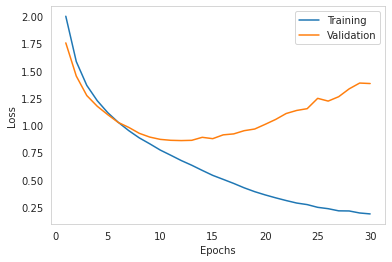

In [ ]:
# plot the learning curve
# plot validation and training loss in the same plot against number of epochs (use `loss_history`)
# YOUR CODE BEGINS HERE
plt.plot(np.arange(1, 31), loss_history["train"], label = "Training")
plt.plot(np.arange(1, 31), loss_history["validation"], label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
# YOUR CODE ENDS HERE

### Questions

1. What do you observe in the learning curve? Why do we require a validation set?
2. Train the network five times. Note the following quantities in a table (in the code cell below):
  - final training loss
  - best model validation loss and accuracy
  - best model test accuracy
3. Summarize your observations from the table. Does the performance differ in each round of training? What would happen if design decisions are based solely on the validation set performance from a single round of training?
4. Propose a scheme to summarize the overall performance of the model with statistics from multiple training rounds. Using the the table in the next cell, write code to summarize model performance.

### Answers

1. We can observe that even though the training loss monotonically decreases, the vallidation loss does not follow the same pattern. Hence, we require the validation set to avoid overfitted model.

2. Done

3. Yes, the performance differs in each round, but not by much.
<br> If the design decisions are based solely on the validation set performance from a single round of training, we might not obtain the best model and test accuracy, as the random nature of the split might have benefitted the validation run due to some patterns being formed, and hence we might obtain a overfitted model on validation data.

4. 


In [ ]:
# fill the table with numbers from different rounds of training (ex: "training loss" : [1.21, 1.53, 0.95, 0.55, 1.14])
perf_table = {
    "training_loss" : [0.20, 0.19, 0.21, 0.19, 0.19],
    "validation_loss" : [0.89, 0.85, 0.88, 0.86, 0.86],
    "validation_accuracy" : [68.42, 72.28, 69.24, 71.26, 70.66],
    "test_accuracy" : [70.40, 70.73, 69.27, 70.56, 70.54]
}

df = pd.DataFrame(perf_table)
print(df)

# YOUR CODE BEGINS HERE
# summarize the performance

# YOUR CODE ENDS HERE

   training_loss  validation_loss  validation_accuracy  test_accuracy
0           0.20             0.89                68.42          70.40
1           0.19             0.85                72.28          70.73
2           0.21             0.88                69.24          69.27
3           0.19             0.86                71.26          70.56
4           0.19             0.86                70.66          70.54
